In [1]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import h5py
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
import sys
sys.path.append('../')
import KMeans
%matplotlib inline
DIR_DATASET = "../data_set/"

In [2]:
filename = "N-CMAPSS_DS04.h5"

In [3]:
def plot_df_color_per_unit(data, variables, labels, size=7, labelsize=17, option='Time', name=None):
    """
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    leg  = []
    fig  = plt.figure(figsize=(size,max(size,rows*2)))
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    unit_sel  = np.unique(data['unit'])
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option=='cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit '+str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        if n==0:
            ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend(leg, loc='best', fontsize=labelsize-2) #lower left
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

In [4]:
# Load data
with h5py.File(DIR_DATASET + filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))

W shape: (9980013, 4)
X_s shape: (9980013, 14)
X_v shape: (9980013, 14)
T shape: (9980013, 10)
A shape: (9980013, 4)


In [5]:
df_A = DataFrame(data=A, columns=A_var)
df_W = DataFrame(data=W, columns=W_var)
df_W['unit'] = df_A['unit'].values


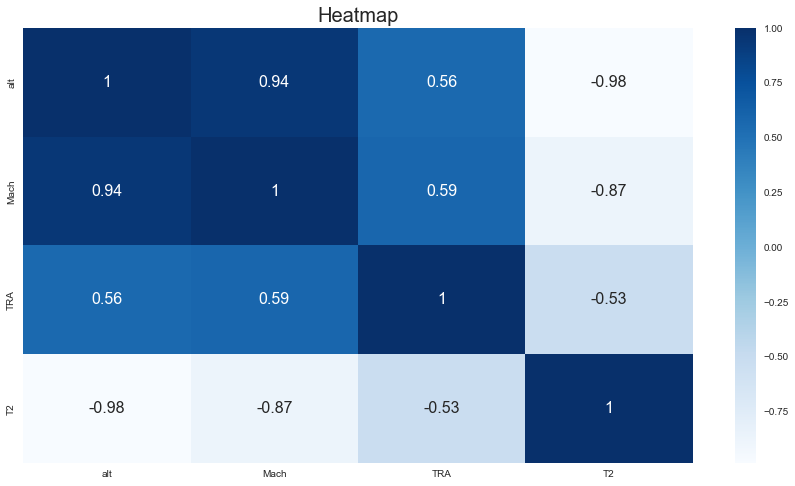

In [6]:
plt.figure(figsize=(15,8))
sns.heatmap(df_W.drop(["unit"], axis=1).corr(), cmap = 'Blues', annot = True, annot_kws={"fontsize": 16})
plt.title('Heatmap', fontsize = 20)

plt.show()

In [7]:
df_X_s = DataFrame(data=X_s, columns=X_s_var) 
df_X_s['unit'] = df_W['unit'].values
df_X_s['alt'] = df_W['alt'].values
df_X_s['Mach'] = df_W['Mach'].values
df_X_s['TRA'] = df_W['TRA'].values
df_X_s['T2'] = df_W['T2'].values
df_X_s['cycle'] = df_A['cycle'].values
df_X_s

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,cycle
0,620.536686,1500.497778,1918.887446,1305.895297,19.186726,13.769427,19.462331,24.474988,420.022739,426.578936,16.312785,2229.036206,8790.661678,5.117880,1.0,3003.0,0.261135,81.386139,514.889127,1.0
1,620.212233,1501.026264,1918.174792,1306.704845,19.168470,13.765780,19.472561,24.482789,419.831067,426.528828,16.314777,2229.338301,8790.557024,5.113072,1.0,3014.0,0.260820,81.386139,514.832078,1.0
2,620.691023,1501.435624,1917.553771,1305.988738,19.161991,13.768780,19.459324,24.487983,419.814866,426.332878,16.303461,2227.314527,8793.731801,5.113295,1.0,3023.0,0.262521,81.386139,514.889656,1.0
3,620.355416,1500.911321,1917.426968,1305.531529,19.171850,13.754179,19.460298,24.493184,419.747243,426.108069,16.310728,2227.793004,8792.134355,5.112996,1.0,3032.0,0.262836,81.386139,514.874556,1.0
4,620.591359,1501.437449,1918.752200,1305.696191,19.161257,13.744312,19.455585,24.458775,419.775992,426.066808,16.285185,2228.217157,8796.438082,5.109202,1.0,3042.0,0.262332,81.386139,514.811204,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980008,575.594962,1300.416493,1537.012644,1138.884044,16.588586,13.928236,16.816479,19.332151,251.698566,256.948591,14.448214,1710.470427,8131.187698,2.458707,10.0,3016.0,0.291501,34.277100,516.547136,85.0
9980009,576.234568,1299.882098,1537.765798,1139.599918,16.574192,13.918071,16.826887,19.309744,251.809845,257.064075,14.456533,1714.111240,8123.240798,2.462037,10.0,3013.0,0.292068,34.277100,516.589850,85.0
9980010,575.367322,1300.168884,1534.960755,1138.679258,16.581624,13.921671,16.832350,19.323433,251.871517,257.033246,14.456594,1710.488984,8132.049740,2.460451,10.0,3010.0,0.291942,34.277100,516.594146,85.0
9980011,575.666962,1301.061768,1535.511495,1139.539488,16.571732,13.930149,16.823578,19.315798,251.751500,257.299571,14.464679,1710.823646,8138.051357,2.460564,10.0,3007.0,0.291312,34.277100,516.567693,85.0


In [8]:
#selezione unita e ciclo
unit=1
cycle=10

<Figure size 432x288 with 0 Axes>

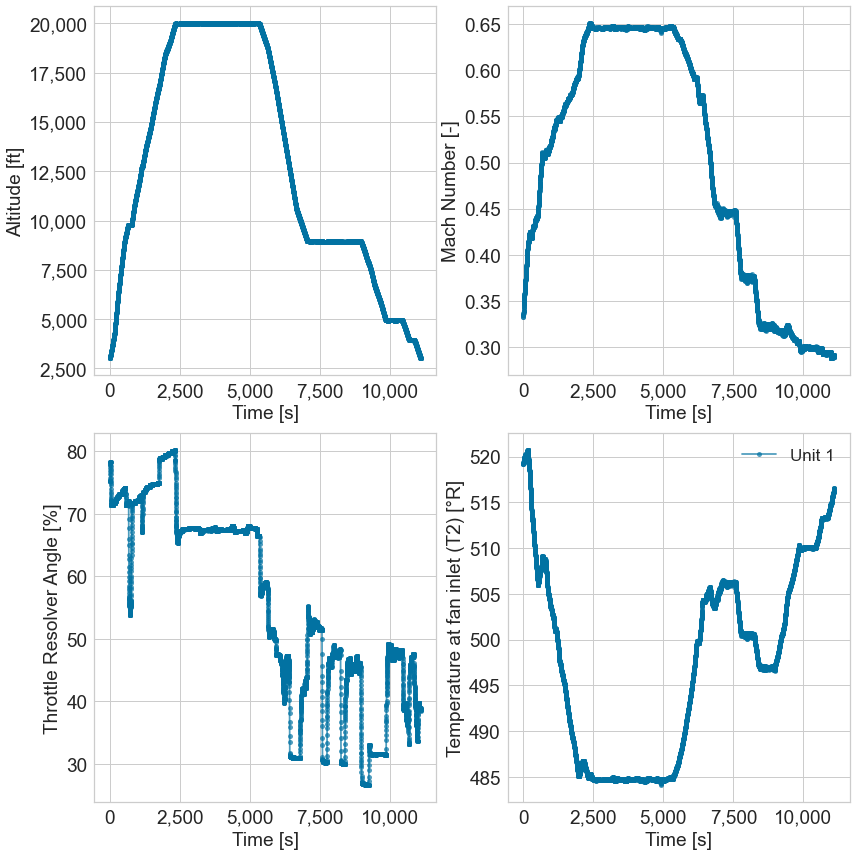

In [9]:
filter1 = df_X_s[df_X_s['unit']==unit]
filter1 = filter1[filter1['cycle']==cycle]
filter1.reset_index(inplace=True, drop=True)
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
plot_df_color_per_unit(filter1, W_var , labels, size=12, labelsize=19, name='./plot/flight_profile_'+ filename.replace('.h5','')+'_unit_'+str(unit)+'_cycle_'+str(cycle)+'.png')

In [10]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import root
x = np.array(np.arange(len(df_X_s)))
y = np.array(df_X_s['alt'].to_list())

# calcolare la derivata
dy_dx = np.gradient(y, x)

# trovare i punti stazionari
stationary_points = x[np.where(dy_dx == 0)[0]]

print(stationary_points)

df_X_s = df_X_s.iloc[stationary_points]
df_X_s.reset_index(inplace=True)

[   2556    2559    2657 ... 9979327 9979328 9979330]


<Figure size 432x288 with 0 Axes>

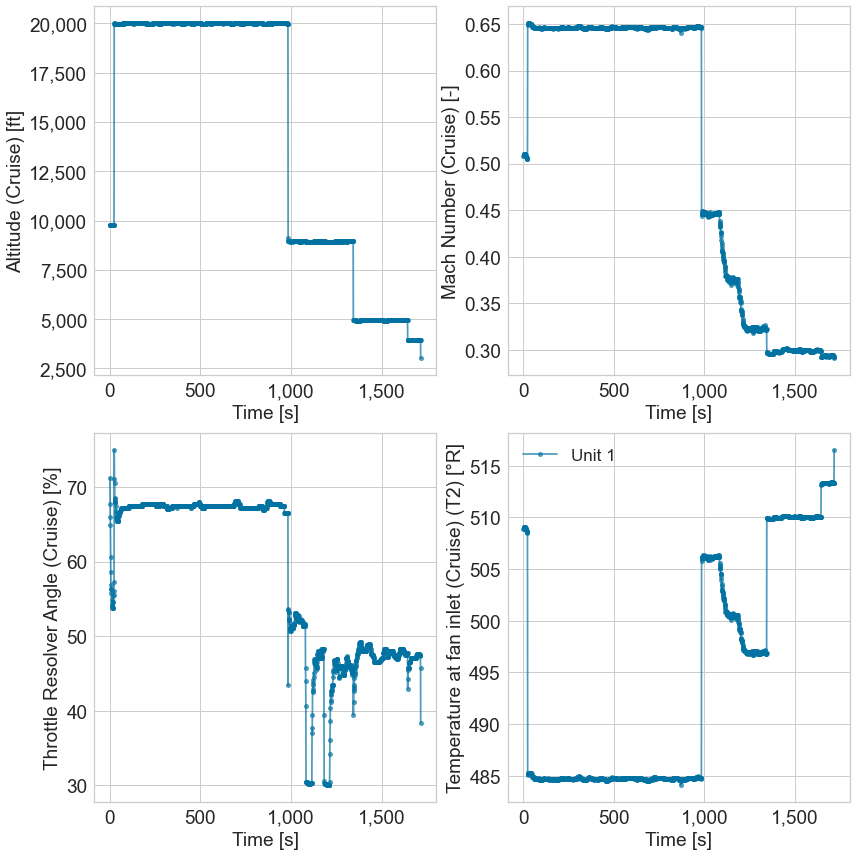

In [11]:
filter2 = df_X_s[df_X_s['unit']==unit]
filter2 = filter2[filter2['cycle']==cycle]
filter2.reset_index(inplace=True, drop=True)
labels = ['Altitude (Cruise) [ft]', 'Mach Number (Cruise) [-]', 'Throttle Resolver Angle (Cruise) [%]', 'Temperature at fan inlet (Cruise) (T2) [°R]']
plot_df_color_per_unit(filter2, W_var , labels, size=12, labelsize=19, name='./plot/flight_profile_'+ filename.replace('.h5','')+'_unit_'+str(unit)+'_cycle_'+str(cycle)+'_cruise_data.png')

## CLUSTERING

-1.6246997108602566e-15 0.9999999999999984
(1202751, 19)


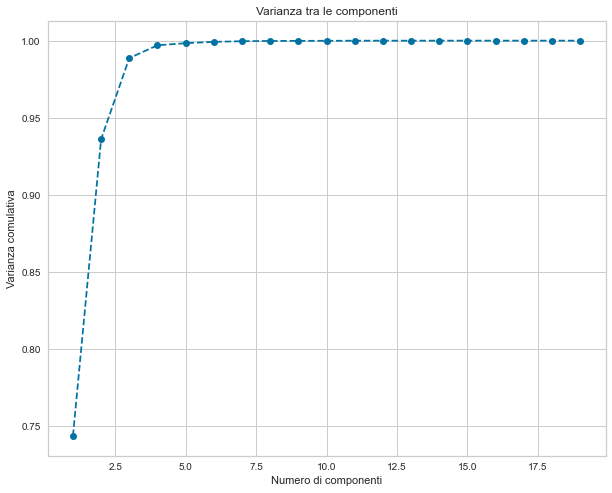

In [12]:
df_X_s_norm = KMeans.normalize_df(df_X_s.drop(columns=["unit",'cycle']))
KMeans.plot_variance_ratio(df_X_s_norm)

it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9
Numero di cluster (k-means): 2


KMeans(n_clusters=2, random_state=42)

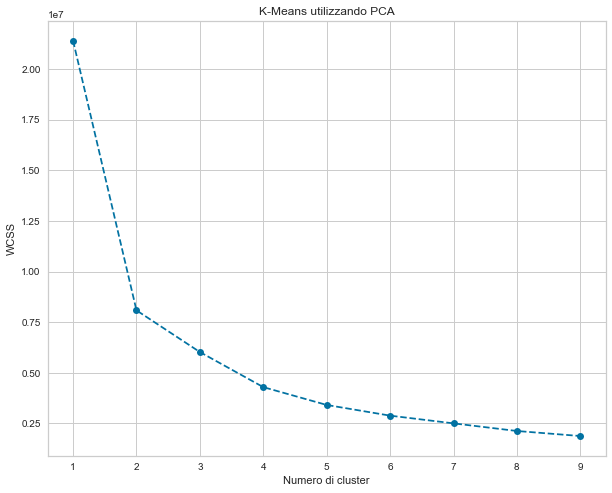

In [13]:
#prendiamo l'80% della varianza comulativa
scores_pca = KMeans.apply_pca(df_X_s_norm,2)
wcss = []
for i in range(1,10):
      kmeans_pca = KMeans.KMeans(n_clusters=i,init='k-means++',random_state=42)
      kmeans_pca.fit(scores_pca)
      wcss.append(kmeans_pca.inertia_)
      print("it",str(i))
plt.figure(figsize=(10,8))
plt.plot(range(1,10),wcss,marker='o',linestyle='--')
plt.title('K-Means utilizzando PCA')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
kl = KneeLocator(range(1,10),wcss,curve="convex",direction="decreasing")
print("Numero di cluster (k-means):",kl.elbow)
kmeans_pca = KMeans.KMeans(n_clusters=kl.elbow,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

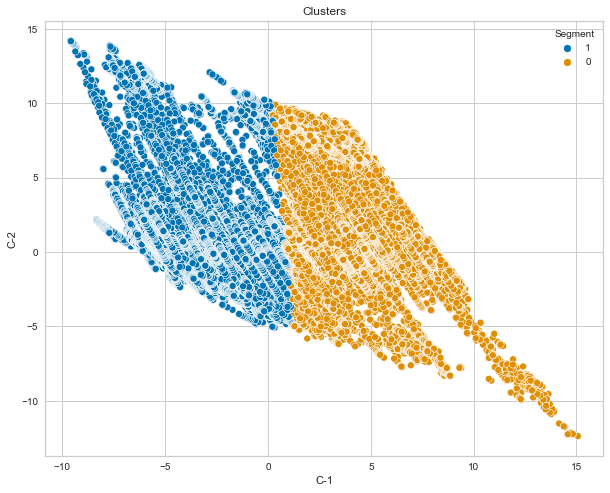

,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,unit,alt,Mach,TRA,T2,cycle,C-1,C-2,Segm K-means PCA,Segment
0,2556,567.795907,1366.322366,1724.662821,1139.269221,10.849925,7.860228,11.018526,13.992674,230.195323,...,1.0,22292.0,0.610596,82.352928,471.918857,1.0,0.158704,-3.755205,1,1
1,2559,567.543924,1366.869882,1725.652522,1139.463421,10.843730,7.874355,11.024681,13.998139,230.277435,...,1.0,22299.0,0.611730,82.352928,472.012398,1.0,0.185095,-3.790194,1,1
2,2657,568.721493,1367.546921,1726.985685,1139.019128,10.887140,7.875738,11.047441,14.036098,229.869194,...,1.0,22543.0,0.627102,82.352928,472.749510,1.0,0.160080,-3.832096,1,1
3,2800,565.108799,1351.829855,1693.107317,1119.055416,10.667390,7.828728,10.814531,13.667880,219.581440,...,1.0,22991.0,0.641781,78.309990,472.652647,1.0,-0.515524,-2.672163,1,1
4,2803,563.961455,1348.912963,1686.263551,1116.642194,10.603437,7.831927,10.775068,13.588522,217.307178,...,1.0,22993.0,0.641970,77.167419,472.666118,1.0,-0.617124,-2.432906,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202746,9979318,574.773030,1325.828014,1597.991106,1146.514698,15.106259,12.222149,15.331644,18.139103,256.774697,...,10.0,6888.0,0.326844,46.845371,504.662906,85.0,4.545166,2.139908,0,0
1202747,9979325,573.313118,1318.231151,1582.644763,1137.923858,15.033722,12.226612,15.253172,17.985427,251.033955,...,10.0,6887.0,0.325836,45.263351,504.601777,85.0,4.251691,2.693445,0,0
1202748,9979327,572.278884,1312.974493,1575.799576,1136.227020,14.979510,12.222172,15.208933,17.903384,248.262674,...,10.0,6886.0,0.325458,44.384449,504.580773,85.0,4.109073,3.009535,0,0
1202749,9979328,571.893563,1313.604659,1573.386554,1136.772669,14.962269,12.231277,15.188798,17.868454,247.722415,...,10.0,6887.0,0.325332,44.032890,504.569497,85.0,4.092575,3.091142,0,0


In [14]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)
KMeans.view_kmeans_results_2d(df_segm_pca_kmeans,scores_pca,kmeans_pca)

In [15]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)

KMeans.calculate_centroids(df_segm_pca_kmeans,scores_pca,"",0)

-7.127367249638446e-16 0.9999999999999996
(448930, 21)
5.11101812472215e-15 1.0000000000000007
(753821, 21)


,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,cycle,group
mean,4.991987e+06,578.922809,1344.690367,1636.935406,1146.656598,14.781942,11.731240,15.007025,17.971780,262.456969,...,1922.779640,8290.491170,2.759206,5.525547,9914.527784,0.448426,53.364589,503.516466,43.543784,0.0
mean,5.006763e+06,552.370455,1311.028558,1628.960922,1082.935643,9.666936,7.294207,9.814141,12.246432,190.435324,...,2038.970533,8184.133515,2.037021,5.540734,25239.455763,0.664065,72.338276,466.583320,43.358028,1.0


Text(0, 0.5, 'Flight Class # [-]')

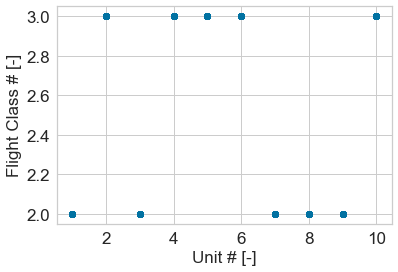

In [16]:
labelsize = 17
plt.plot(df_A.unit, df_A.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

In [17]:
dic = {}
for i in range(1,len(set(df_A.unit))+1):
    dic[i] = int(df_A[df_A.unit==i]["Fc"].iloc[0])
dic

{1: 2, 2: 3, 3: 2, 4: 3, 5: 3, 6: 3, 7: 2, 8: 2, 9: 2, 10: 3}

In [18]:
df_segm_pca_kmeans['class'] = df_segm_pca_kmeans['unit'].map(dic)
df_segm_pca_kmeans

,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,alt,Mach,TRA,T2,cycle,C-1,C-2,Segm K-means PCA,Segment,class
0,2556,567.795907,1366.322366,1724.662821,1139.269221,10.849925,7.860228,11.018526,13.992674,230.195323,...,22292.0,0.610596,82.352928,471.918857,1.0,0.158704,-3.755205,1,1,2
1,2559,567.543924,1366.869882,1725.652522,1139.463421,10.843730,7.874355,11.024681,13.998139,230.277435,...,22299.0,0.611730,82.352928,472.012398,1.0,0.185095,-3.790194,1,1,2
2,2657,568.721493,1367.546921,1726.985685,1139.019128,10.887140,7.875738,11.047441,14.036098,229.869194,...,22543.0,0.627102,82.352928,472.749510,1.0,0.160080,-3.832096,1,1,2
3,2800,565.108799,1351.829855,1693.107317,1119.055416,10.667390,7.828728,10.814531,13.667880,219.581440,...,22991.0,0.641781,78.309990,472.652647,1.0,-0.515524,-2.672163,1,1,2
4,2803,563.961455,1348.912963,1686.263551,1116.642194,10.603437,7.831927,10.775068,13.588522,217.307178,...,22993.0,0.641970,77.167419,472.666118,1.0,-0.617124,-2.432906,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202746,9979318,574.773030,1325.828014,1597.991106,1146.514698,15.106259,12.222149,15.331644,18.139103,256.774697,...,6888.0,0.326844,46.845371,504.662906,85.0,4.545166,2.139908,0,0,3
1202747,9979325,573.313118,1318.231151,1582.644763,1137.923858,15.033722,12.226612,15.253172,17.985427,251.033955,...,6887.0,0.325836,45.263351,504.601777,85.0,4.251691,2.693445,0,0,3
1202748,9979327,572.278884,1312.974493,1575.799576,1136.227020,14.979510,12.222172,15.208933,17.903384,248.262674,...,6886.0,0.325458,44.384449,504.580773,85.0,4.109073,3.009535,0,0,3
1202749,9979328,571.893563,1313.604659,1573.386554,1136.772669,14.962269,12.231277,15.188798,17.868454,247.722415,...,6887.0,0.325332,44.032890,504.569497,85.0,4.092575,3.091142,0,0,3


In [19]:
for i in range(0,3):
    filtered = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"]==i]
    contatori = filtered['class'].value_counts()
    df_contatori = pd.DataFrame({'Classe': contatori.index, 'Conteggio': contatori.values})
    print("cluster",i)
    print(df_contatori)
    print("totale cluster",i,":",df_contatori["Conteggio"].sum())


cluster 0
   Classe  Conteggio
0       3     226562
1       2     222368
totale cluster 0 : 448930
cluster 1
   Classe  Conteggio
0       3     520181
1       2     233640
totale cluster 1 : 753821
cluster 2
Empty DataFrame
Columns: [Classe, Conteggio]
Index: []
totale cluster 2 : 0


In [21]:
df_segm_pca_kmeans_f = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"] == 1]
df_W_u = df_segm_pca_kmeans_f[df_segm_pca_kmeans_f.unit == 8]
df_W_u.reset_index(inplace=True, drop=True)
df_W_u
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
#plot_df_color_per_unit(df_W_u, W_var , labels, size=12, labelsize=19, name='flight_profile_DS02_clustering.png')
print('min:',df_W_u['alt'].min())
print('max:',df_W_u['alt'].max())

min: 9864.0
max: 29018.0
